In [1]:
import jax
import equinox as eqx
import diffrax as dfx
import jax.numpy as jnp
import jax.random as jrandom
import jax.scipy as jcp 
import optax
import math
from typing import Callable, List
import jax.nn as jnn
import jax.numpy as jnp
import ipdb
from jax import jit
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import time
import os
from jax import Array
from diffrax.custom_types import PyTree, Scalar, Union
import warnings
from scipy.special import gammaln
import sys
sys.path.append('../')
from copy import deepcopy
warnings.filterwarnings("ignore")
from simulated_system.controller import Controller
from simulated_system.data import *
from simulated_system.train import *
from data import *
import pickle
import yaml


(array([0, 1, 2], dtype=int32), array([16, 25, 59]))


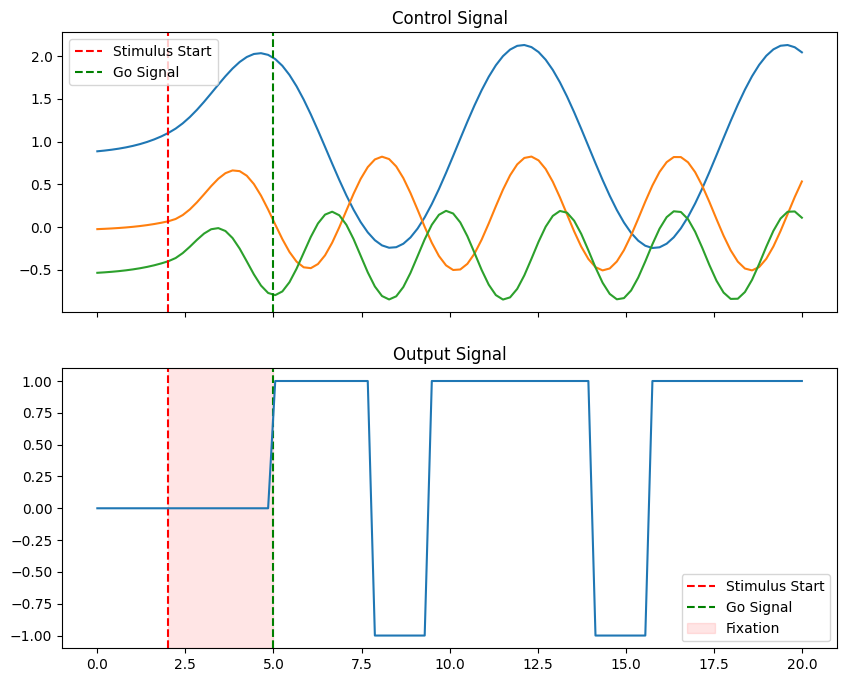

In [2]:
noise_scale = 10.0

config_path = '../configs/pilot.yaml'
with open(config_path) as f:
    config = yaml.safe_load(f)
config['data']['process_noise_scale'] = noise_scale
key = jrandom.PRNGKey(9)
ts = jnp.linspace(0, config['data']['trial_time'], config['data']['n_timepoints'])
t_stim = config['data']['t_stim']
t_wait = config['data']['t_wait']
t_go = t_stim + t_wait
C = config['data']['control_size']
loader = Sys_Dataloader(100, config, key)
controls, outputs =loader.sample_observations(0)
print(np.unique(jnp.argmax(outputs[1],axis=-1), return_counts=True))
plotting(ts, controls, outputs, t_stim, t_go)

Train with noise scale 0.0
Step: 0, Train Loss: 1.10, Train Accuracy: 0.36 || Val Loss: 1.07, Val Accuracy: 0.53
Saving best model
Step: 200, Train Loss: 0.20, Train Accuracy: 0.95 || Val Loss: 0.20, Val Accuracy: 0.95
Saving best model
Step: 400, Train Loss: 0.08, Train Accuracy: 0.98 || Val Loss: 0.08, Val Accuracy: 0.97
Saving best model
Step: 600, Train Loss: 0.06, Train Accuracy: 0.98 || Val Loss: 0.06, Val Accuracy: 0.98
Saving best model
Step: 800, Train Loss: 0.05, Train Accuracy: 0.98 || Val Loss: 0.05, Val Accuracy: 0.98
Saving best model
Step: 1000, Train Loss: 0.03, Train Accuracy: 0.99 || Val Loss: 0.03, Val Accuracy: 0.99
Saving best model


NameError: name 'ts' is not defined

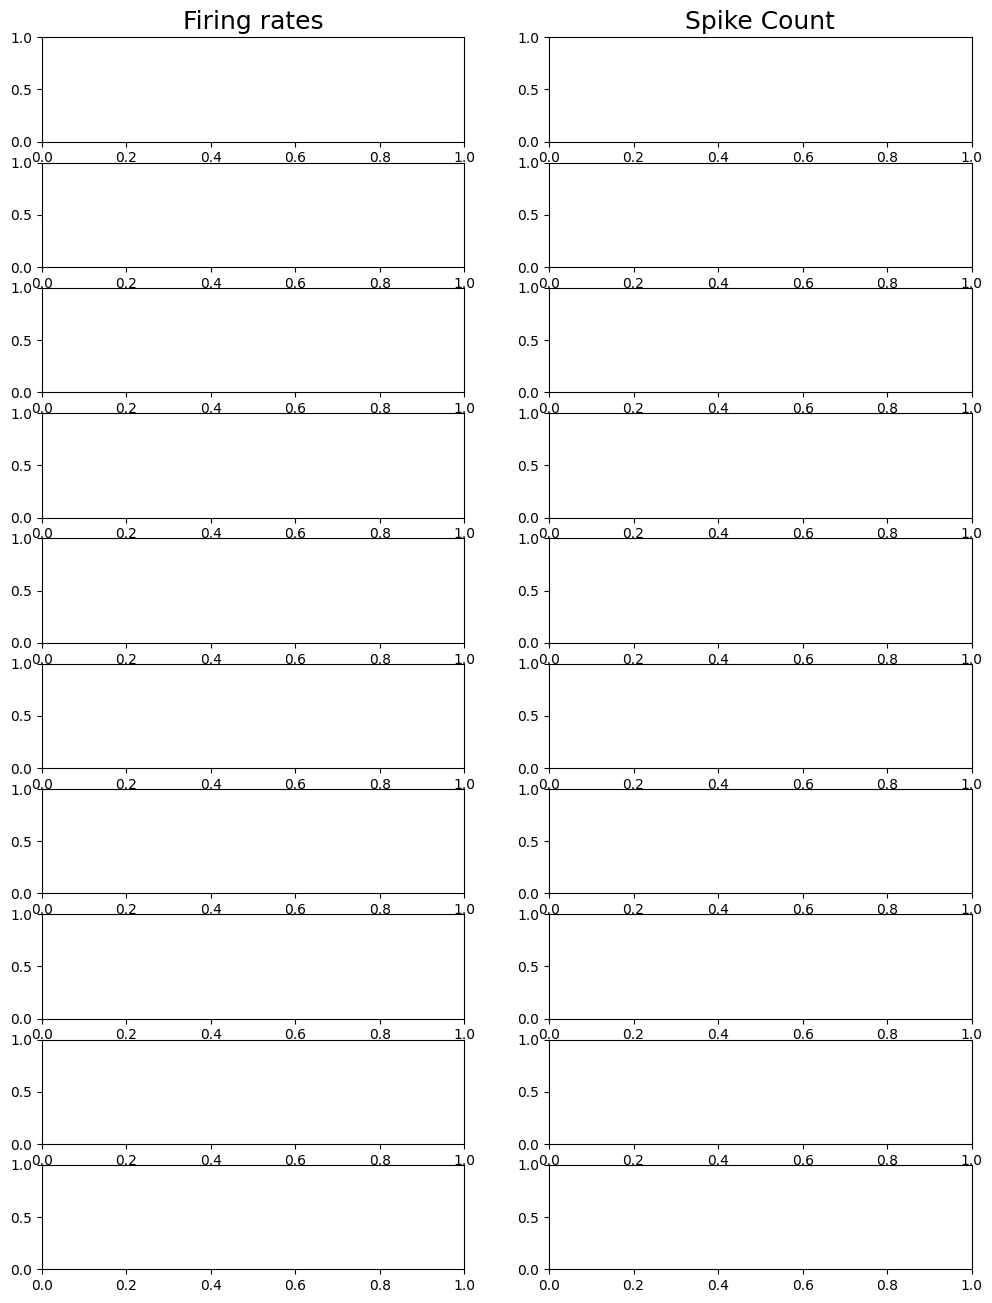

In [3]:
noise_scales = [0.0, 1.0, 5.0, 10.0]
key = jrandom.PRNGKey(0)
config_path = '../configs/pilot.yaml'
ts = jnp.linspace(0, config['data']['trial_time'], config['data']['n_timepoints'])

with open(config_path) as f:
    config = yaml.safe_load(f)
for noise_scale in noise_scales:
    print(f'Train with noise scale {noise_scale}')
    config['data']['process_noise_scale'] = noise_scale
    trained_system = train_gt(key, config)
    system_loader  = Dataloader(trained_system, 64, config, key)
    controls, spikes, rates, obs = system_loader.sample_observations(1)
    rates = rates[1]
    spikes = spikes[1]

    # Plot the rates and the spikes in two adjacent subplots
    fig, ax = plt.subplots(10,2, figsize=(12,16))
    # Add a big title at the top
    ax[0][0].set_title('Firing rates', fontsize=18)
    ax[0][1].set_title('Spike Count' , fontsize=18)
    # Add vertical space between the title and the subplots
    for neuron in range(10):
        ax[neuron][0].plot(ts, rates[:,neuron], label=f'Neuron {neuron}', color='red', linewidth=1.5)
        ax[neuron][1].plot(ts, spikes[:,neuron], label=f'Neuron {neuron}', color='blue', linewidth=2.0)
        #ax[neuron][0].legend()
        #ax[neuron][1].legend()
        # set limits  
        ax[neuron][0].set_ylim([0, 1.5])
        ax[neuron][1].set_ylim([0,4.5])
        
        # set ticks to none
        ax[neuron][0].set_xticks([])
        ax[neuron][0].set_yticks([])
        ax[neuron][1].set_xticks([])
        ax[neuron][1].set_yticks([])
        # set x label to be Neuron i 
        ax[neuron][0].set_ylabel(f'Neuron {neuron+1}', fontsize=12)

    plt.tight_layout()
    # transparent background

    plt.savefig(f'../figures/gt_noise/noise={noise_scale}.png', transparent=True)
    print(f'Saved figure to ../figures/gt_noise/noise={noise_scale}.png')
    print('----------------------------------------------')